In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, classification_report

from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
#from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
#from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from nltk import word_tokenize

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import auc, roc_auc_score, roc_curve, confusion_matrix, classification_report

from keras.models import Model, load_model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from tensorflow.keras.optimizers import RMSprop
#from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
#from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# for dirname, _, filenames in os.walk('/kaggle/working'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

In [ ]:
data = pd.DataFrame(pd.read_excel('/content/drive/MyDrive/camerounaise_spam_data.xlsx'))
scale_mapper = {"spam":0,
"Spam":0,
"h":1,
"ham":1}
data_label= data["v1"].replace(scale_mapper)
data.rename(columns = {'v1':'label','v2':'SMS'},inplace=True)
# Checking the rows and columns(m*n)
data = (data[['label','SMS']].dropna()).sample(frac = 1)
data.shape
# Checking for the nulls
data.info()
# Re-Checking for nulls
data.isnull().sum()
# Row-wise all values are displayed
data.values

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20616 entries, 10323 to 10947
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   20616 non-null  object
 1   SMS     20616 non-null  object
dtypes: object(2)
memory usage: 483.2+ KB


array([['ham', 'Ils ne sont pas marie'],
       ['ham', "Une année pleine de difficultés s'annonce.\n"],
       ['ham',
        'Cher client, il vous reste 50Mo dans votre sous-compte Orange Bonus Data. Renouvelez votre forfait avant expiration au #111*1# ou sur My Orange et recevez le double!'],
       ...,
       ['ham', '\u200eJoël TCF Ndere.vcf (fichier joint)'],
       ['ham',
        'exactement le Cameroun a sa façon de fonctionner...ça se négocie hein'],
       ['ham',
        'Hummmm ma sœur tu ris, yen à qui ont même parfois 40 de température sans avoir le palu ohh']],
      dtype=object)

In [ ]:
balance_counts = data.groupby('label')['label'].agg('count').values
balance_counts

array([17561,  3055])

In [ ]:
# Libraries needed for NLP
import nltk
import re

# Stopwords
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

# Stemmers
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer

# Lemmatizermodel.add(Dropout(0.2))
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
!pip install fasttext

In [ ]:
import fasttext

PRETRAINED_MODEL_PATH = '/content/drive/MyDrive/fastext/lid.176.bin'
model_fastext = fasttext.load_model(PRETRAINED_MODEL_PATH)


In [ ]:
data_sms = []
text = []
# Store it in a variable
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# Cleanup
# Store it in a variable
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def clean_data_en(text):
  '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
  # replace email address with 'emailaddress'
  text = re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', r'emailadress', str(text))
  # replace urls with 'webaddress'
  text = re.sub('(https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)', r'webaddress', str(text))
  # replace 10 digit phone number with 'phone-number'
  text =  re.sub('(?:\d{8}(?:\d{2}(?:\d{2})?)?|\(\+?\d{2,3}\)\s?(?:\d{4}[\s*.-]?\d{4}|\d{3}[\s*.-]?\d{3}|\d{2}([\s*.-]?)\d{2}\1\d{2}(?:\1\d{2})?))', r'phone-number', text)
  # replace normal number with 'number'
  text = re.sub('\d+(\.\d+)?', r'number', text)
  # remove punctuation
  text=re.sub('[^\w\d\s]', r' ',text)
  # remove whitespace between terms with single space
  text = re.sub('\s+', r' ', text)
  # remove leading and trailing whitespace
  text = re.sub('^\s+|\s*?$', r' ',text)
  # change words to lower case
  text = text.lower()
  return textmodel.add(Dropout(0.2))

def clean_data_fr(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
      and remove words containing numbers.'''
    # replace email address with 'emailaddress'
    text = re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', r'adresseemail', str(text))
    # replace urls with 'webaddress'
    text = re.sub('(https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)', r'adresseweb', str(text))
    # replace 10 digit phone number with 'phone-number'
    text =  re.sub('(?:\d{8}(?:\d{2}(?:\d{2})?)?|\(\+?\d{2,3}\)\s?(?:\d{4}[\s*.-]?\d{4}|\d{3}[\s*.-]?\d{3}|\d{2}([\s*.-]?)\d{2}\1\d{2}(?:\1\d{2})?))', r'phone-number', text)
    # replace normal number with 'number'
    text = re.sub('\d+(\.\d+)?', r'numero', text)
    # remove punctuation
    text=re.sub('[^\w\d\s]', r' ',text)
    # remove whitespace between terms with single space
    text = re.sub('\s+', r' ', text)
    # remove leading and trailing whitespace
    text = re.sub('^\s+|\s*?$', r' ',text)
    # change words to lower case
    text = text.lower()
    return text


In [ ]:
data_sms = []
text = []
# Store it in a variable
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
# Cleanup
# Store it in a variable
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()
def clean_data_en(text):
  '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
  # replace email address with 'emailaddress'
  text = re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', r'emailadress', text)
  # replace urls with 'webaddress'
  text = re.sub('([http//[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)| (https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)|(www.https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)|(www.http//[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)', r'webaddress', text)
  # replace 10 digit phone number with 'phone-number'
  text =  re.sub('[\+|@| ]237[\-|\~|\.| ]6[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ]*[0-9]{2}|[\+|@| ]237[\-|\~|\.| ]6 *[0-9]{2}[\-|\~|\.| ] *[0-9]{3}[\-|\~|\.| ] *[0-9]{3}|[\+|@| ]2376 *[0-9]{8}|00237[\-|\~|\.| ]6 *[0-9]{2}[\-|\~|\.| ] *[0-9]{3}[\-|\~|\.| ] *[0-9]{3}|00237[\-|\~|\.| ]6[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ]*[0-9]{2}|6[2|3|5-9] *[0-9]{7}|6[2|3|5-9]*[0-9]{1}[\-|\.|\~|:| ]*[0-9]{3}[\-|\.|\~|:| ]*[0-9]{3}|6[2|3|5-9]*[0-9]{1}[\-|\.|\~|:| ]*[0-9]{2}[\-|\.|\~|:| ]*[0-9]{2}[\-|\.|\~|:| ]*[0-9]{2}|[\+|@| ]237[\-|\~|\.| ]6[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ]*[0-9]{2}|[\+|@| ]237[\-|\~|\.| ]6 *[0-9]{2}[\-|\~|\.| ] *[0-9]{3}[\-|\~|\.| ] *[0-9]{3}|[\+|@| ]2376 *[0-9]{8}|00237[\-|\~|\.| ]6 *[0-9]{2}[\-|\~|\.| ] *[0-9]{3}[\-|\~|\.| ] *[0-9]{3}|00237[\-|\~|\.| ]6[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ]*[0-9]{2}', r'phone-number', str(text))
  # change words to lower case
  text = re.sub('(https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)', r' url', text)
  text = re.sub('(00237[1-9] *[0-9]{8}|\+237[1-9] *[0-9]{8}|(237[1-9] *[0-9]{8})|(6[2|3|5-9] *[0-9]{7}))', r' phoneNumber', text)
  text = re.sub('(?:\d{8}(?:\d{2}(?:\d{2})?)?|\(\+?\d{2,3}\)\s?(?:\d{4}[\s*.-]?\d{4}|\d{3}[\s*.-]?\d{3}|\d{2}([\s*.-]?)\d{2}\1\d{2}(?:\1\d{2})?))', r' phoneNumber', text)
  text = re.sub('\$ *[0-9|,|.]{1,10}|[\d]{1,10}[0-9|,|.]{0,10}\$|[\d]{1,10}[0-9|,|.]{0,10} \$', r' moneySymbol', text)
  text = re.sub('[\d]{1,10}U|[\d]{1,10} u|[\d]{1,10} U|[\d]{1,10}[0-9|,|.]{0,10}u|[\d]{1,10}[0-9|,|.]{0,10} u|[\d]{1,10}[0-9|,|.]{0,10} U| [\d]{1,10}[0-9|,|.]{0,10} U|U *[0-9|,|.]{1,10}|u *[0-9|,|.]{1,10}', r' moneySymbol', text)
  text = re.sub('[\d]{1,10} million|[\d]{1,10}million|[\d]{1,10}milliard|[\d]{1,10} milliard|million *[0-9|,|.]{1,10}|milliard *[0-9|,|.]{1,10}|[\d]{1,10}[0-9|,|.]{0,10}milliards|[\d]{1,10}[0-9|,|.]{0,10}million|[\d]{1,10}[0-9|,|.]{0,10} millions|[\d]{1,10}[0-9|,|.]{0,10} milliards', r' moneySymbol', text)
  text = re.sub('[\d]{1,10}[0-9|,|.]{0,10}FCFA|[\d]{1,10}[0-9|,|.]{0,10} FCFA|[\d]{1,10}[0-9|,|.]{0,10}fcfa|[\d]{1,10}[0-9|,|.]{0,10} fcfa|[\d]{1,10}fcfa|[\d]{1,10}FCFA|[\d]{1,10} fcfa|[\d]{1,10} FCFA|[\d]{1,10} CFAF|FCFA *[0-9|,|.]{1,10}|[\d]{1,10} XAF|[\d]{1,10} F|[\d]{1,10}F|[\d]{1,10}f|[\d]{1,10} f|[\d]{1,10}Fr|[\d]{1,10}fr|[\d]{1,10} Fr|[\d]{1,10} fr|[\d]{1,10} XAF|[\d]{1,10} F|[\d]{1,10}F|[\d]{1,10}f|[\d]{1,10} f|[\d]{1,10}Fr|[\d]{1,10}fr|[\d]{1,10} Fr|[\d]{1,10} fr|[\d]{1,10}[0-9|,|.]{0,10}f|[\d]{1,10}[0-9|,|.]{0,10} f|f *[0-9|,|.]{1,10}', r' moneySymbol', text)
  text = re.sub('[\d]{1,10}[0-9|,|.]{0,10} Mb|[\d]{1,10}[0-9|,|.]{0,10}Mb|[\d]{1,10}[0-9|,|.]{0,10}MB|[\d]{1,10}[0-9|,|.]{0,10} MB|[\d]{1,10}MB|[\d]{1,10}Mb|[\d]{1,10} MB|[\d]{1,10}GB|[\d]{1,10}gb|[\d]{1,10}[0-9|,|.]{0,10} GB|[\d]{1,10}[0-9|,|.]{0,10} gb|[\d]{1,10}MO|[\d]{1,10}Mo|[\d]{1,10}mO|[\d]{1,10}mo|[\d]{1,10} MO|[\d]{1,10} Mo|[\d]{1,10} mO|[\d]{1,10} mo|[\d]{1,10}[0-9|,|.]{0,10}mo|[\d]{1,10}[0-9|,|.]{0,10}mO|[\d]{1,10}[0-9|,|.]{0,10}Mo|[\d]{1,10}[0-9|,|.]{0,10}MO|[\d]{1,10}[0-9|,|.]{0,10} mo|[\d]{1,10}[0-9|,|.]{0,10} mO|[\d]{1,10}[0-9|,|.]{0,10} Mo|[\d]{1,10}[0-9|,|.]{0,10} MO|[\d]{1,10}GO|[\d]{1,10}Go|[\d]{1,10}gO|[\d]{1,10}go|[\d]{1,10} GO|[\d]{1,10} Go|[\d]{1,10} gO|[\d]{1,10} go|[\d]{1,10}[0-9|,|.]{0,10}go|[\d]{1,10}[0-9|,|.]{0,10}gO|[\d]{1,10}[0-9|,|.]{0,10}Go|[\d]{1,10}[0-9|,|.]{0,10}GO|[\d]{1,10}[0-9|,|.]{0,10} go|[\d]{1,10}[0-9|,|.]{0,10} gO|[\d]{1,10}[0-9|,|.]{0,10} Go|[\d]{1,10}[0-9|,|.]{0,10} GO|[\d]{1,10}[0-9|,|.]{0,10} Mega|[\d]{1,10}[0-9|,|.]{0,10}Mega|[\d]{1,10}Mega|[\d]{1,10} Mega', r' dataConnexion', text)
  text = re.sub('[\*|\#][0-9]{1,3}[*\|#]*[0-9]{1,3}[\*|\#]*[0-9]{1,3}[\*|\#]|[\*|\#][0-9]{3}\#|[\*|\#][0-9]{3}[*\|#] *[0-9]{1,3}[\*|\#]', r' codeSymbol',text)
  text = re.sub('([http//[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)| (https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)|(www.https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)|(www.http//[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)', r' adressWeb', text)
  # replace normal number with 'number'
  text = re.sub('\d+(\.\d+)?', r'number', text)
  # remove punctuation
  text=re.sub('[^\w\d\s]', r' ',text)
  # remove whitespace between terms with single space
  text = re.sub('\s+', r' ', text)
  # remove leading and trailing whitespace
  text = re.sub('^\s+|\s*?$', r' ',text)
  text = text.lower()
  return text

def clean_data_fr(text):
  '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
  and remove words containing numbers.'''
  # replace email address with 'emailaddress'
  text = re.sub('([A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,})', r'adresseMail', text)
  # replace urls with 'webaddress'
  text = re.sub('([http//[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)| (https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)|(www.https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)|(www.http//[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)', r'webaddress', text)
  # replace 10 digit phone number with 'phone-number'
  text =  re.sub('[\+|@| ]237[\-|\~|\.| ]6[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ]*[0-9]{2}|[\+|@| ]237[\-|\~|\.| ]6 *[0-9]{2}[\-|\~|\.| ] *[0-9]{3}[\-|\~|\.| ] *[0-9]{3}|[\+|@| ]2376 *[0-9]{8}|00237[\-|\~|\.| ]6 *[0-9]{2}[\-|\~|\.| ] *[0-9]{3}[\-|\~|\.| ] *[0-9]{3}|00237[\-|\~|\.| ]6[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ]*[0-9]{2}|6[2|3|5-9] *[0-9]{7}|6[2|3|5-9]*[0-9]{1}[\-|\.|\~|:| ]*[0-9]{3}[\-|\.|\~|:| ]*[0-9]{3}|6[2|3|5-9]*[0-9]{1}[\-|\.|\~|:| ]*[0-9]{2}[\-|\.|\~|:| ]*[0-9]{2}[\-|\.|\~|:| ]*[0-9]{2}|[\+|@| ]237[\-|\~|\.| ]6[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ]*[0-9]{2}|[\+|@| ]237[\-|\~|\.| ]6 *[0-9]{2}[\-|\~|\.| ] *[0-9]{3}[\-|\~|\.| ] *[0-9]{3}|[\+|@| ]2376 *[0-9]{8}|00237[\-|\~|\.| ]6 *[0-9]{2}[\-|\~|\.| ] *[0-9]{3}[\-|\~|\.| ] *[0-9]{3}|00237[\-|\~|\.| ]6[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ] *[0-9]{2}[\-|\~|\.| ]*[0-9]{2}', r' NumeroPhone', text)
  # change words to lower case
  text = re.sub('(https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)', r' url',text)
  text = re.sub('(00237[1-9] *[0-9]{8}|\+237[1-9] *[0-9]{8}|(237[1-9] *[0-9]{8})|(6[2|3|5-9] *[0-9]{7}))', r' NumeroPhone', text)
  text = re.sub('(?:\d{8}(?:\d{2}(?:\d{2})?)?|\(\+?\d{2,3}\)\s?(?:\d{4}[\s*.-]?\d{4}|\d{3}[\s*.-]?\d{3}|\d{2}([\s*.-]?)\d{2}\1\d{2}(?:\1\d{2})?))', r' NumeroPhone', text)
  text = re.sub('\$ *[0-9|,|.]{1,10}|[\d]{1,10}[0-9|,|.]{0,10}\$|[\d]{1,10}[0-9|,|.]{0,10} \$', r' SymboleArgent', text)
  text = re.sub('[\d]{1,10}U|[\d]{1,10} u|[\d]{1,10} U|[\d]{1,10}[0-9|,|.]{0,10}u|[\d]{1,10}[0-9|,|.]{0,10} u|[\d]{1,10}[0-9|,|.]{0,10} U| [\d]{1,10}[0-9|,|.]{0,10} U|U *[0-9|,|.]{1,10}|u *[0-9|,|.]{1,10}', r' SymboleMonnaie', text)
  text = re.sub('[\d]{1,10} million|[\d]{1,10}million|[\d]{1,10}milliard|[\d]{1,10} milliard|million *[0-9|,|.]{1,10}|milliard *[0-9|,|.]{1,10}|[\d]{1,10}[0-9|,|.]{0,10}milliards|[\d]{1,10}[0-9|,|.]{0,10}million|[\d]{1,10}[0-9|,|.]{0,10} millions|[\d]{1,10}[0-9|,|.]{0,10} milliards', r' SymboleMonnaie', text)
  text = re.sub('[\d]{1,10}[0-9|,|.]{0,10}FCFA|[\d]{1,10}[0-9|,|.]{0,10} FCFA|[\d]{1,10}[0-9|,|.]{0,10}fcfa|[\d]{1,10}[0-9|,|.]{0,10} fcfa|[\d]{1,10}fcfa|[\d]{1,10}FCFA|[\d]{1,10} fcfa|[\d]{1,10} FCFA|[\d]{1,10} CFAF|FCFA *[0-9|,|.]{1,10}|[\d]{1,10} XAF|[\d]{1,10} F|[\d]{1,10}F|[\d]{1,10}f|[\d]{1,10} f|[\d]{1,10}Fr|[\d]{1,10}fr|[\d]{1,10} Fr|[\d]{1,10} fr|[\d]{1,10} XAF|[\d]{1,10} F|[\d]{1,10}F|[\d]{1,10}f|[\d]{1,10} f|[\d]{1,10}Fr|[\d]{1,10}fr|[\d]{1,10} Fr|[\d]{1,10} fr|[\d]{1,10}[0-9|,|.]{0,10}f|[\d]{1,10}[0-9|,|.]{0,10} f|f *[0-9|,|.]{1,10}', r' SymboleMonnaie', text)
  text = re.sub('[\d]{1,10}[0-9|,|.]{0,10} Mb|[\d]{1,10}[0-9|,|.]{0,10}Mb|[\d]{1,10}[0-9|,|.]{0,10}MB|[\d]{1,10}[0-9|,|.]{0,10} MB|[\d]{1,10}MB|[\d]{1,10}Mb|[\d]{1,10} MB|[\d]{1,10}GB|[\d]{1,10}gb|[\d]{1,10}[0-9|,|.]{0,10} GB|[\d]{1,10}[0-9|,|.]{0,10} gb|[\d]{1,10}MO|[\d]{1,10}Mo|[\d]{1,10}mO|[\d]{1,10}mo|[\d]{1,10} MO|[\d]{1,10} Mo|[\d]{1,10} mO|[\d]{1,10} mo|[\d]{1,10}[0-9|,|.]{0,10}mo|[\d]{1,10}[0-9|,|.]{0,10}mO|[\d]{1,10}[0-9|,|.]{0,10}Mo|[\d]{1,10}[0-9|,|.]{0,10}MO|[\d]{1,10}[0-9|,|.]{0,10} mo|[\d]{1,10}[0-9|,|.]{0,10} mO|[\d]{1,10}[0-9|,|.]{0,10} Mo|[\d]{1,10}[0-9|,|.]{0,10} MO|[\d]{1,10}GO|[\d]{1,10}Go|[\d]{1,10}gO|[\d]{1,10}go|[\d]{1,10} GO|[\d]{1,10} Go|[\d]{1,10} gO|[\d]{1,10} go|[\d]{1,10}[0-9|,|.]{0,10}go|[\d]{1,10}[0-9|,|.]{0,10}gO|[\d]{1,10}[0-9|,|.]{0,10}Go|[\d]{1,10}[0-9|,|.]{0,10}GO|[\d]{1,10}[0-9|,|.]{0,10} go|[\d]{1,10}[0-9|,|.]{0,10} gO|[\d]{1,10}[0-9|,|.]{0,10} Go|[\d]{1,10}[0-9|,|.]{0,10} GO|[\d]{1,10}[0-9|,|.]{0,10} Mega|[\d]{1,10}[0-9|,|.]{0,10}Mega|[\d]{1,10}Mega|[\d]{1,10} Mega', r' DonneeConnexion', text)
  text = re.sub('[\*|\#][0-9]{1,3}[*\|#]*[0-9]{1,3}[\*|\#]*[0-9]{1,3}[\*|\#]|[\*|\#][0-9]{3}\#|[\*|\#][0-9]{3}[*\|#] *[0-9]{1,3}[\*|\#]', r' SymboleCode',text)
  text = re.sub('([http//[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)| (https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)|(www.https://[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)|(www.http//[a-zA-Z0-9\-\.]+\.[a-zA-Z]{2,3}(/\S*)?$)', r' adresseWeb', text)
  # replace normal number with 'number'
  text = re.sub('\d+(\.\d+)?', r' nombre', text)
  # remove punctuation
  text=re.sub('[^\w\d\s]', r' ',text)
  # remove whitespace between terms with single space
  text = re.sub('\s+', r' ', text)
  # remove leading and trailing whitespace
  text = re.sub('^\s+|\s*?$', r' ',text)
  text = text.lower()
  return text

In [ ]:
    from nltk.corpus import stopwords

    more_stopwords = ['u', 'im', 'c']
    englishStopWord = stopwords.words("english")
    frenchStopWord = stopwords.words("french")
    englishStopWord = stopwords.words("english") + more_stopwords
    french_english =  englishStopWord +frenchStopWord
    def testFuncOld(text):
        text = ' '.join([word for word in text.split() if word not in englishStopWord])
        return text

    def testFrenchEnglish(text):
        text = ' '.join([word for word in text.split() if word not in french_english])
        return text

    def testFuncNew(text):
        text = ' '.join([word for word in text.split() if word not in text])
        return text

        #remove french stop word
    def testFuncOldFrench(text):
        text = ' '.join([word for word in text.split() if word not in stopwords.words("french")])
        return text

    def testFuncNewFrench(text):
        text = ' '.join([word for word in text.split() if word not in text])
        return text

    def eliminer(text):
      text = str(text).replace('\n', ' ')
      predictions = model_fastext.predict(text)
      if predictions[0][0] == '__label__fr':
        text = clean_data_fr(text)
        text = testFuncOldFrench(text)
      elif predictions[0][0] == '__label__en':
        text = clean_data_en(text)
        text = testFuncOld(text)
      else:
        clean_data_en(text)
        text = clean_data_fr(text)
        text = testFrenchEnglish(text)
      return text


In [ ]:
data['message_clean'] = data['SMS'].apply(eliminer)

In [ ]:
print(data['message_clean'][0])

yvana dors prdn


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
le.fit(data['label'])

data['label_encoded'] = le.transform(data['label'])
print(data['label_encoded'][0])
print(len(data['message_clean'][0]))

0
15


In [ ]:
# how to define X and y (from the SMS data) for use with COUNTVECTORIZER
x = data['message_clean'][:1000]
y = data['label_encoded'][:1000]

print(len(x), len(y))

1000 1000


In [ ]:
# Split into train and test sets
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, random_state=20)
print(len(x_train), len(y_train))
print(len(x_test), len(y_test))


750 750
250 250


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

# instantiate the vectorizer
vect = CountVectorizer()
vect.fit(x_train)

CountVectorizer()

In [ ]:
# Use the trained to create a document-term matrix from train and test sets
x_train_dtm = vect.transform(x_train)
x_test_dtm = vect.transform(x_test)


In [ ]:
print(x_train_dtm[1])

  (0, 63)	1
  (0, 495)	1
  (0, 730)	1
  (0, 1532)	1


In [ ]:
vect_tunned = CountVectorizer(stop_words='english', ngram_range=(1,2), min_df=0.1, max_df=0.7, max_features=100)

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer

tfidf_transformer = TfidfTransformer()

tfidf_transformer.fit(x_train_dtm)
x_train_tfidf = tfidf_transformer.transform(x_train_dtm)

x_train_tfidf

<750x2488 sparse matrix of type '<class 'numpy.float64'>'
	with 6122 stored elements in Compressed Sparse Row format>

In [ ]:
texts = data['message_clean']
target = data['label_encoded']

In [ ]:
# Calculate the length of our vocabulary
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(texts)

vocab_length = len(word_tokenizer.word_index) + 1
vocab_length

16121

In [ ]:
import tensorflow as tf
from numpy import array
from keras.utils import pad_sequences

from keras.layers import Dense
sequences = [[1], [2, 3], [4, 5, 6]]
tf.keras.preprocessing.sequence.pad_sequences(
    sequences, maxlen=None, dtype='int32', padding='pre',
    truncating='pre', value=0.0
)


array([[0, 0, 1],
       [0, 2, 3],
       [4, 5, 6]], dtype=int32)

In [ ]:
tf.keras.preprocessing.sequence.pad_sequences(sequences, padding='post')

array([[1, 0, 0],
       [2, 3, 0],
       [4, 5, 6]], dtype=int32)

In [ ]:
def embed(corpus):
    return word_tokenizer.texts_to_sequences(corpus)

longest_train = max(texts, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))

train_padded_sentences = pad_sequences(
    embed(texts),
    length_long_sentence,
    padding='post'
)



In [ ]:
!unzip '/content/drive/MyDrive/glove.6B.zip'

Archive:  /content/drive/MyDrive/glove.6B.zip
replace glove.6B.50d.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
embeddings_dictionary = dict()
embedding_dim = 100

# Load GloVe 100D embeddings
with open('/content/glove.6B.100d.txt') as fp:
    for line in fp.readlines():
        records = line.split()
        word = records[0]
        vector_dimensions = np.asarray(records[1:], dtype='float32')
        embeddings_dictionary [word] = vector_dimensions

# embeddings_dictionary

In [ ]:
# Now we will load embedding vectors of those words that appear in the
# Glove dictionary. Others will be initialized to 0.

embedding_matrix = np.zeros((vocab_length, embedding_dim))

for word, index in word_tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector



MultiNominal Naive Baise

In [ ]:
# Create a Multinomial Naive Bayes model
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()

# Train the model
nb.fit(x_train_dtm, y_train)

MultinomialNB()

In [ ]:
# Make class anf probability predictions
y_pred_class = nb.predict(x_test_dtm)
y_pred_prob = nb.predict_proba(x_test_dtm)[:, 1]

In [ ]:
!python3 -m pip show scikit-learn

Name: scikit-learn
Version: 1.2.2
Summary: A set of python modules for machine learning and data mining
Home-page: http://scikit-learn.org
Author: 
Author-email: 
License: new BSD
Location: /usr/local/lib/python3.10/dist-packages
Requires: joblib, numpy, scipy, threadpoolctl
Required-by: bigframes, fastai, imbalanced-learn, librosa, mlxtend, qudida, shap, sklearn-pandas, yellowbrick


In [ ]:
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

print(classification_report(y_test, y_pred_class))
# Calculate AUC
metrics.roc_auc_score(y_test, y_pred_prob)

              precision    recall  f1-score   support

           0       0.99      0.98      0.98       218
           1       0.88      0.91      0.89        32

    accuracy                           0.97       250
   macro avg       0.93      0.94      0.94       250
weighted avg       0.97      0.97      0.97       250



0.9852350917431194

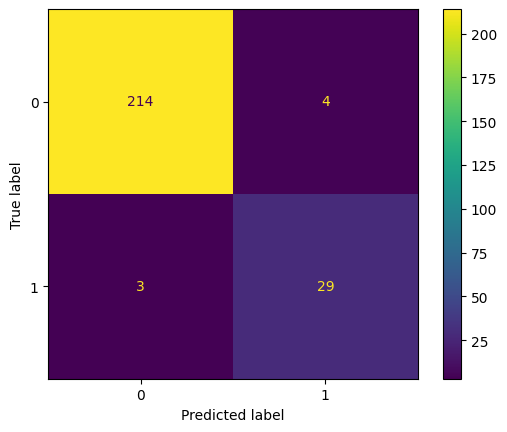

0.972
[[214   4]
 [  3  29]]


In [ ]:
# calculate accuracy of class predictions
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_class)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(metrics.accuracy_score(y_test, y_pred_class))

print(metrics.confusion_matrix(y_test, y_pred_class))

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline

pipe = Pipeline([('bow', CountVectorizer()),
                 ('tfid', TfidfTransformer()),
                 ('model', MultinomialNB())])

In [ ]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class_naive = pipe.predict(x_test)

print(metrics.accuracy_score(y_test, y_pred_class_naive))

print(metrics.confusion_matrix(y_test, y_pred_class_naive))
metrics.roc_auc_score(y_test, y_pred_class_naive)

0.952
[[218   0]
 [ 12  20]]


0.8125

In [ ]:
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

print(classification_report(y_test, y_pred_class_naive))


              precision    recall  f1-score   support

           0       0.95      1.00      0.97       218
           1       1.00      0.62      0.77        32

    accuracy                           0.95       250
   macro avg       0.97      0.81      0.87       250
weighted avg       0.95      0.95      0.95       250



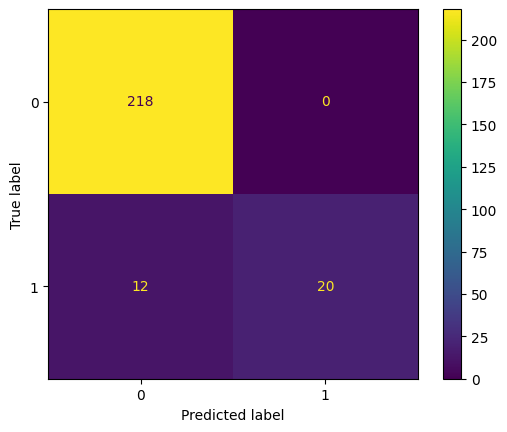

0.952
[[218   0]
 [ 12  20]]


In [ ]:
# calculate accuracy of class predictions
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_class_naive)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(metrics.accuracy_score(y_test, y_pred_class_naive))

print(metrics.confusion_matrix(y_test, y_pred_class_naive))

Xgboost

In [ ]:
import xgboost as xgb

pipe = Pipeline([
    ('bow', CountVectorizer()),
    ('tfid', TfidfTransformer()),
    ('model', xgb.XGBClassifier(
        learning_rate=0.1,
        max_depth=7,
        n_estimators=80,
        use_label_encoder=False,
        eval_metric='auc',
        # colsample_bytree=0.8,
        # subsample=0.7,
        # min_child_weight=5,
    ))
])

In [ ]:
# Fit the pipeline with the data
pipe.fit(x_train, y_train)

y_pred_class_xgb = pipe.predict(x_test)
y_pred_train = pipe.predict(x_train)

print('Train: {}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Test: {}'.format(metrics.accuracy_score(y_test, y_pred_class_xgb)))

print(metrics.confusion_matrix(y_test, y_pred_class_xgb))



Train: 0.9973333333333333
Test: 0.968
[[218   0]
 [  8  24]]


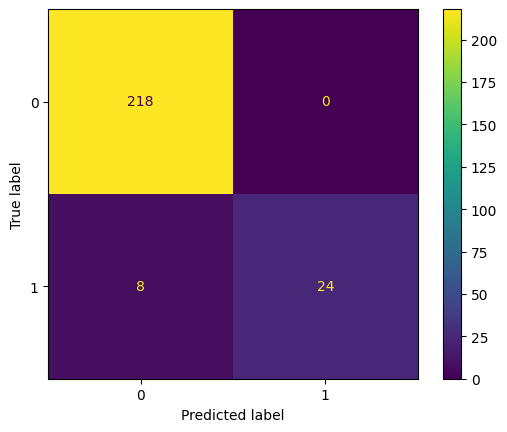

0.968
[[218   0]
 [  8  24]]


In [ ]:
# calculate accuracy of class predictions
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_pred_class_xgb)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(metrics.accuracy_score(y_test, y_pred_class_xgb))

print(metrics.confusion_matrix(y_test, y_pred_class_xgb))

In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    train_padded_sentences,
    target,
    test_size=0.20
)


In [ ]:
!pip install shap

In [ ]:
import shap
shap.initjs() # JavaScript plots

#create explainer

In [ ]:
print(len(X_train[16400:]))

92


In [ ]:
# Import the necessary module
import shap

# Initialize JS for SHAP plots
shap.initjs()

# Access the model object from the pipeline
model = pipe.steps[-1][1]

# Create the explainer
explainer = shap.Explainer(model, X_train[16400:])

# Calculate SHAP values for the training data
shap_values = explainer(X_train[:160:])

Bi-LSTM model training

In [ ]:
# Model from https://www.kaggle.com/mariapushkareva/nlp-disaster-tweets-with-glove-and-lstm/data
from keras.models import Sequential
from tensorflow.keras.layers import Bidirectional
from keras import Sequential, Model
from keras.layers import Embedding,LSTM, GlobalMaxPool1D
from tensorflow.keras.layers import BatchNormalization

def glove_lstm():
    model = Sequential()

    model.add(Embedding(
        input_dim=embedding_matrix.shape[0],
        output_dim=embedding_matrix.shape[1],
        weights = [embedding_matrix],
        input_length=length_long_sentence
    ))

    model.add(Bidirectional(LSTM(
        length_long_sentence,
        return_sequences = True,
        recurrent_dropout=0.2
    )))

    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

    return model

model = glove_lstm()
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 152, 100)          1611100   
                                                                 
 bidirectional (Bidirection  (None, 152, 304)          307648    
 al)                                                             
                                                                 
 global_max_pooling1d (Glob  (None, 304)               0         
 alMaxPooling1D)                                                 
                                                                 
 batch_normalization (Batch  (None, 304)               1216      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 304)               0         
                                                        

In [ ]:
# Load the model and train!!
from keras.callbacks import ReduceLROnPlateau

model = glove_lstm()

checkpoint = ModelCheckpoint(
    'model.h5',
    monitor = 'val_loss',
    verbose = 1,
    save_best_only = True
)
reduce_lr = ReduceLROnPlateau(
    monitor = 'val_loss',
    factor = 0.2,
    verbose = 1,
    patience = 5,
    min_lr = 0.001
)
history = model.fit(
    X_train,
    y_train,
    epochs = 5,
    batch_size = 32,
    validation_data = (X_test, y_test),
    verbose = 1,
    callbacks = [reduce_lr, checkpoint]
)

Epoch 1/5
516/516 [==============================] - ETA: 0s - loss: 0.1501 - accuracy: 0.9545
Epoch 1: val_loss improved from inf to 0.18232, saving model to model.h5
516/516 [==============================] - 579s 1s/step - loss: 0.1501 - accuracy: 0.9545 - val_loss: 0.1823 - val_accuracy: 0.9500 - lr: 0.0010
Epoch 2/5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


516/516 [==============================] - ETA: 0s - loss: 0.0676 - accuracy: 0.9808
Epoch 2: val_loss improved from 0.18232 to 0.03948, saving model to model.h5
516/516 [==============================] - 573s 1s/step - loss: 0.0676 - accuracy: 0.9808 - val_loss: 0.0395 - val_accuracy: 0.9905 - lr: 0.0010
Epoch 3/5
516/516 [==============================] - ETA: 0s - loss: 0.0513 - accuracy: 0.9867
Epoch 3: val_loss did not improve from 0.03948
516/516 [==============================] - 590s 1s/step - loss: 0.0513 - accuracy: 0.9867 - val_loss: 0.1032 - val_accuracy: 0.9719 - lr: 0.0010
Epoch 4/5
516/516 [==============================] - ETA: 0s - loss: 0.0428 - accuracy: 0.9892
Epoch 4: val_loss did not improve from 0.03948
516/516 [==============================] - 565s 1s/step - loss: 0.0428 - accuracy: 0.9892 - val_loss: 0.1205 - val_accuracy: 0.9777 - lr: 0.0010
Epoch 5/5
516/516 [==============================] - ETA: 0s - loss: 0.0423 - accuracy: 0.9901
Epoch 5: val_loss improv

In [ ]:
from mlxtend.plotting import plot_learning_curves
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']], clf)


NameError: name 'clf' is not defined

129/129 [==============================] - 20s 148ms/step


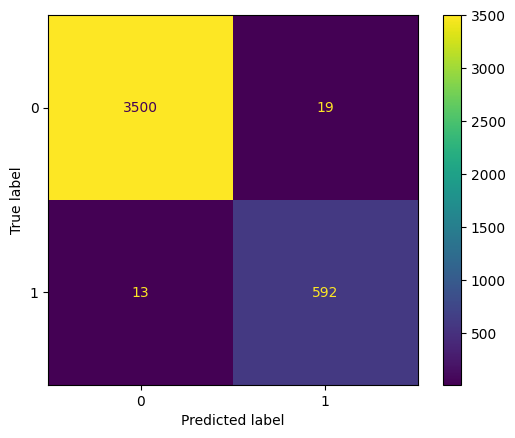

0.9922405431619786


In [ ]:
y_preds_lstm = (model.predict(X_test) > 0.5).astype("int32")
# calculate accuracy of class predictions
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_preds_lstm)
color = 'white'
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
print(metrics.accuracy_score(y_test, y_preds_lstm))

In [ ]:
from sklearn.metrics import classification_report
import sklearn.metrics as metrics

print(classification_report(y_test, y_preds_lstm))


              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3519
           1       0.97      0.98      0.97       605

    accuracy                           0.99      4124
   macro avg       0.98      0.99      0.98      4124
weighted avg       0.99      0.99      0.99      4124



Bert transformer model training

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
!pip install transformers
import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [ ]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=maximum_length,
            pad_to_max_length=True,

            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])

    return np.array(input_ids),np.array(attention_masks)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
texts = data['message_clean']
target = data['label_encoded']

train_input_ids, train_attention_masks = bert_encode(texts,60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):

    input_ids = tf.keras.Input(shape=(60,),dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,),dtype='int32')

    output = bert_model([input_ids,attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(12,activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1,activation='sigmoid')(output)

    model = tf.keras.models.Model(inputs = [input_ids,attention_masks],outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [ ]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 input_2 (InputLayer)        [(None, 60)]                 0         []                            
                                                                                                  
 tf_bert_model (TFBertModel  TFBaseModelOutputWithPooli   1094822   ['input_1[0][0]',             
 )                           ngAndCrossAttentions(last_   40         'input_2[0][0]']             
                             hidden_state=(None, 60, 76                                           
                             8),                                                              

In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2,
    epochs=2,
    batch_size=20
)

Epoch 1/2
237/825 [=======>......................] - ETA: 2:27:01 - loss: 0.4616 - accuracy: 0.8561

In [ ]:
plot_learning_curves(history, [['loss', 'val_loss'],['accuracy', 'val_accuracy']])